In [1]:
# set work dir
import os
os.chdir("../pkg")

In [2]:
import time
import random
import pyepo
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
# fix random seed
random.seed(135)
np.random.seed(135)
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Load Data

We use the Warcraft terrains shortest paths [dateset](https://edmond.mpdl.mpg.de/dataset.xhtml?persistentId=doi:10.17617/3.YJCQ5S). Datasets were randomly generated from the Warcraft II [tileset](http://github.com/war2/war2edit) and used in Vlastelica, Marin, et al. "Differentiation of Blackbox Combinatorial Solvers".

In [3]:
# map size
k = 12

### Maps 

In [4]:
tmaps_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_maps.npy".format(k,k))
tmaps_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_maps.npy".format(k,k))

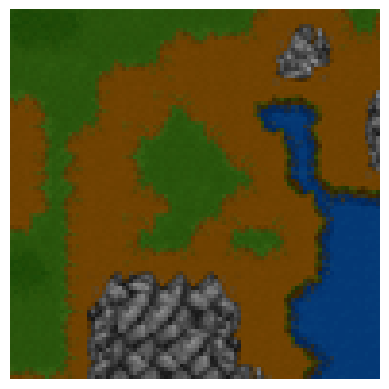

In [5]:
plt.axis("off")
plt.imshow(tmaps_train[0])
plt.show()

### Costs 

In [6]:
costs_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_vertex_weights.npy".format(k,k))
costs_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_vertex_weights.npy".format(k,k))

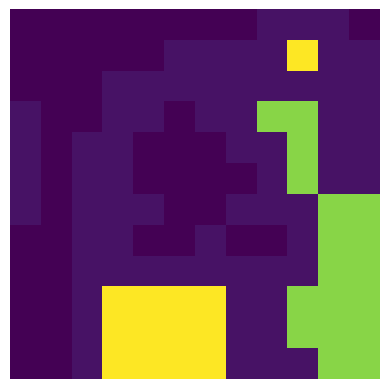

In [7]:
plt.axis("off")
plt.imshow(costs_train[0])
plt.show()

### Paths 

In [8]:
paths_train = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/train_shortest_paths.npy".format(k,k))
paths_test = np.load("../data/warcraft_shortest_path_oneskin/{}x{}/test_shortest_paths.npy".format(k,k))

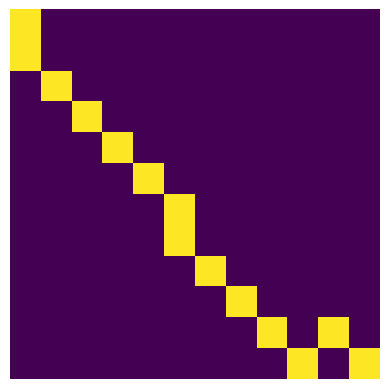

In [9]:
plt.axis("off")
plt.imshow(paths_train[0])
plt.show()

## Data Loader 

In [10]:
from torch.utils.data import Dataset
class mapDataset(Dataset):
    def __init__(self, tmaps, costs, paths):
        self.tmaps = tmaps
        self.costs = costs
        self.paths = paths
        self.objs = (costs * paths).sum(axis=(1,2)).reshape(-1,1)
        
    def __len__(self):
        return len(self.costs)
    
    def __getitem__(self, ind):
        return (
            torch.FloatTensor(self.tmaps[ind].transpose(2, 0, 1)/255).detach(), # image
            torch.FloatTensor(self.costs[ind]),
            torch.FloatTensor(self.paths[ind]),
            torch.FloatTensor(self.objs[ind]),
        )

In [11]:
# datasets
dataset_train = mapDataset(tmaps_train, costs_train, paths_train)
dataset_test = mapDataset(tmaps_test, costs_test, paths_test)

In [12]:
# dataloader
from torch.utils.data import DataLoader
batch_size = 70
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Neural Network: Part of Resnet18 with Max Pooling

In [13]:
from torchvision.models import resnet18
nnet = resnet18(pretrained=False)
print(nnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
# build new ResNet18 with Max Pooling
class partialResNet(nn.Module):
    
    def __init__(self, k):
        super(partialResNet, self).__init__()
        # init resnet 18
        resnet = resnet18(pretrained=False)
        # first five layers of ResNet18
        self.conv1 = resnet.conv1
        self.bn = resnet.bn1
        self.relu = resnet.relu
        self.maxpool1 = resnet.maxpool
        self.block = resnet.layer1
        # conv to 1 channel
        self.conv2  = nn.Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
        # max pooling
        self.maxpool2 = nn.AdaptiveMaxPool2d((k,k))
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.bn(h)
        h = self.relu(h)
        h = self.maxpool1(h)
        h = self.block(h)
        h = self.conv2(h)
        out = self.maxpool2(h)
        return torch.squeeze(out, 1)

## Optimization Model: Linear Programming 

In [15]:
import gurobipy as gp
from gurobipy import GRB

from pyepo.model.grb.grbmodel import optGrbModel

class shortestPathModel(optGrbModel):
    """
    This class is optimization model for shortest path problem on 2D grid with 8 neighbors

    Attributes:
        _model (GurobiPy model): Gurobi model
        grid (tuple of int): Size of grid network
        nodes (list): list of vertex
        edges (list): List of arcs
        nodes_map (ndarray): 2D array for node index
    """

    def __init__(self, grid):
        """
        Args:
            grid (tuple of int): size of grid network
        """
        self.grid = grid
        self.nodes, self.edges, self.nodes_map = self._getEdges()
        super().__init__()

    def _getEdges(self):
        """
        A method to get list of edges for grid network

        Returns:
            list: arcs
        """
        # init list
        nodes, edges = [], []
        # init map from coord to ind
        nodes_map = {}
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                u = self._calNode(i, j)
                nodes_map[u] = (i,j)
                nodes.append(u)
                # edge to 8 neighbors
                # up
                if i != 0:
                    v = self._calNode(i-1, j)
                    edges.append((u,v))
                    # up-right
                    if j != self.grid[1] - 1:
                        v = self._calNode(i-1, j+1)
                        edges.append((u,v))
                # right
                if j != self.grid[1] - 1:
                    v = self._calNode(i, j+1)
                    edges.append((u,v))
                    # down-right
                    if i != self.grid[0] - 1:
                        v = self._calNode(i+1, j+1)
                        edges.append((u,v))
                # down
                if i != self.grid[0] - 1:
                    v = self._calNode(i+1, j)
                    edges.append((u,v))
                    # down-left
                    if j != 0:
                        v = self._calNode(i+1, j-1)
                        edges.append((u,v))
                # left
                if j != 0:
                    v = self._calNode(i, j-1)
                    edges.append((u,v))
                    # top-left
                    if i != 0:
                        v = self._calNode(i-1, j-1)
                        edges.append((u,v))
        return nodes, edges, nodes_map
    
    def _calNode(self, x, y):
        """
        A method to calculate index of node
        """
        v = x * self.grid[1] + y
        return v

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.edges, ub=1, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = self._calNode(i, j)
                expr = 0
                for e in self.edges:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x
    
    def setObj(self, c):
        """
        A method to set objective function

        Args:
            c (np.ndarray): cost of objective function
        """
        obj = c[0,0] + gp.quicksum(c[self.nodes_map[j]] * self.x[i,j] for i, j in self.x)
        self._model.setObjective(obj)
        
    def solve(self):
        """
        A method to solve model

        Returns:
            tuple: optimal solution (list) and objective value (float)
        """
        # update gurobi model
        self._model.update()
        # solve
        self._model.optimize()
        # kxk solution map
        sol = np.zeros(self.grid)
        for i, j in self.edges:
            # active edge
            if abs(1 - self.x[i,j].x) < 1e-3:
                # node on active edge
                sol[self.nodes_map[i]] = 1
                sol[self.nodes_map[j]] = 1
        return sol, self._model.objVal

In [16]:
# init model
grid = (k, k)
optmodel = shortestPathModel(grid)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-07-09


Obj: 26.998046875
Path:


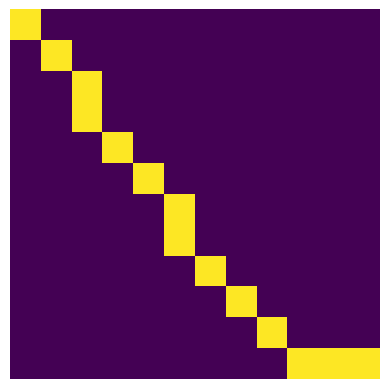

In [17]:
# test
optmodel.setObj(costs_train[0]) # assign cost
sol, obj = optmodel.solve() # solve
print("Obj: {}".format(obj))
print("Path:")
plt.axis("off")
plt.imshow(sol)
plt.show()

## Functions 

In [18]:
def plotLearningCurve(loss_log, regret_log):
    # draw loss during training
    plt.figure(figsize=(8, 4))
    plt.plot(loss_log, color="c")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Iters", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.title("Learning Curve on Training Set", fontsize=16)
    plt.show()
    # draw normalized regret on test
    plt.figure(figsize=(8, 4))
    plt.plot(regret_log, color="royalblue")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Normalized Regret", fontsize=16)
    plt.title("Learning Curve on Test Set", fontsize=16)
    plt.show()

## Two-Stage 

In [19]:
# init net
nnet = partialResNet(k=12)
# cuda
if torch.cuda.is_available():
    nnet = nnet.cuda()
# set optimizer
lr = 5e-4
optimizer = torch.optim.Adam(nnet.parameters(), lr=lr)
# number of epochs
epochs = 50

In [20]:
# set loss
mseloss = nn.MSELoss()

In [21]:
# train
loss_log, regret_log = [], []
for epoch in range(epochs):
    for x, c, w, z in loader_train:
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = nnet(x) # predicted cost
        loss = mseloss(cp, c) # loss
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # log
        loss_log.append(loss.item())
        # scheduled learning rate
        if (epoch == 30) or (epoch == 40):
            for g in optimizer.param_groups:
                g['lr'] /= 10
    if epoch % 10 == 0:
        # regret
        regret = pyepo.metric.regret(nnet, optmodel, loader_test)
        # log
        print("Epoch {:3}, Loss: {:8.4f}, Regret: {:7.4f}%".format(epoch, loss.item(), regret*100))
        regret_log.append(regret)

Epoch   0, Loss:   0.8648, Regret:  3.7050%
Epoch  10, Loss:   0.4750, Regret:  0.9514%
Epoch  20, Loss:   0.4377, Regret:  0.7029%
Epoch  30, Loss:   0.3366, Regret:  0.5431%
Epoch  40, Loss:   0.3217, Regret:  0.5498%


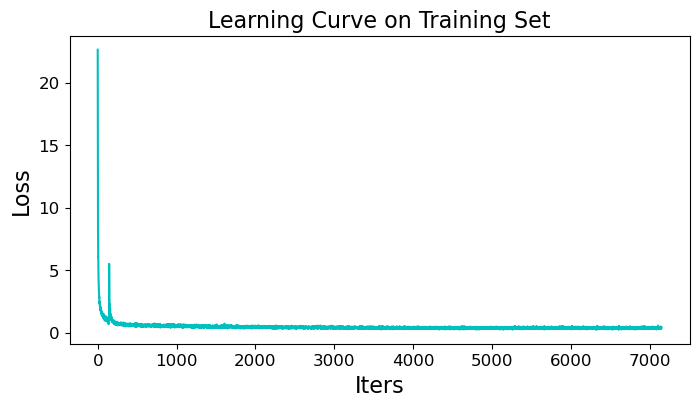

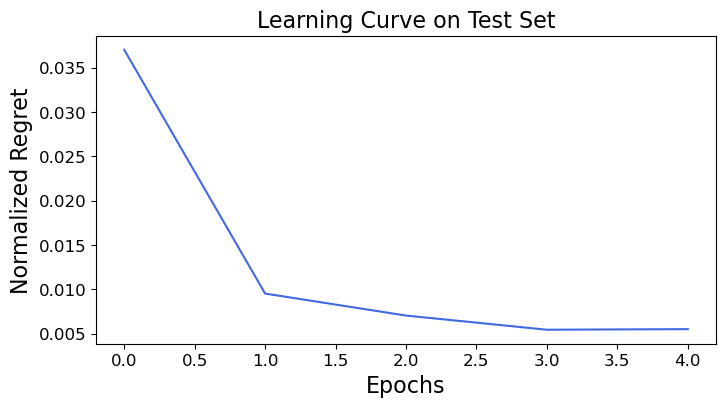

In [22]:
plotLearningCurve(loss_log, regret_log)